In [1]:
import numpy as np
import time
import h5py
import os
import torch
from resnet import resnet18, resnet34, resnet50
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
%matplotlib inline

In [2]:
def model_test(model,faces,device):
    model = model.to(device)
    model.eval()
    predicts = []
    for i in range(faces.shape[0]):
        inpt = torch.FloatTensor(np.transpose(faces[i:i+1],(0,3,1,2))).to(device)
        out = model(inpt)
        predicts.append(out.data.cpu().numpy())
    scores = np.array(predicts)[:,0]
#     preds = np.argmax(pred[:,0],axis=1)
#     t = (preds ==  labels)
#     accuracy = np.sum(t)/len(t)
    return np.exp(scores)

def cal_genu_impost_distri(scores,labels):
    assert np.max(scores) <= 1
    assert np.min(scores) >= 0
    
    genuine_scores = []
    imposter_scores = []
    for i in range(len(labels)):
        pre_score = list(scores[i])
        genuine_scores.append(pre_score[labels[i]])
        del pre_score[labels[i]]
        imposter_scores.append(pre_score)
    return np.reshape(np.array(genuine_scores),(-1)),np.reshape(np.array(imposter_scores),(-1))

def draw_genu_impost_distri(genuine_scores,imposter_scores):
    bins = np.linspace(0,1,1000)
    myarray = genuine_scores
    weights = np.ones_like(myarray)/float(len(myarray))
    _ = plt.hist(myarray,bins=bins, weights=weights)
    myarray = imposter_scores
    weights = np.ones_like(myarray)/float(len(myarray))
    _ = plt.hist(myarray,bins=bins, weights=weights)
    
    plt.legend(('genuine distribution', 'imposter distribution'),
           loc='upper center', shadow=True)
    plt.xlabel('scores')
    plt.ylabel('probability')
    plt.show()
    
def cal_accuracy(scores,labels):
    t = (np.argmax(scores,axis=1) == labels)
    return np.sum(t)/len(t)

def cal_ROC(genuine_scores,imposter_scores):
    threshold = np.linspace(0,1,100)
    FAR = []
    FRR = []
    for h in threshold:
        false_reject = np.sum(genuine_scores<=h)/len(genuine_scores)
        false_accept = np.sum(imposter_scores>h)/len(imposter_scores)
        FAR.append(false_accept)
        FRR.append(false_reject)
    return FAR,FRR

def find_rank(score,label):
    rank = 1
    while (np.max(score)>0):
        if np.argmax(score) == label:
            return rank
        else:
            score[np.argmax(score)] = 0
            rank +=1

def cal_CMC(scores,labels):
    CMC = np.zeros(len(labels))
    for i in range(len(labels)):
        score = scores[i]
        label = labels[i]
        rank =find_rank(score,label)
        CMC[rank-1:] += 1
    return CMC/np.max(CMC)

In [3]:
hf = h5py.File('./dataset.h5', 'r')
faces_val = np.array(hf.get('faces_val'))/255
labels_val = np.array(hf.get('labels_val'))
faces_train = np.array(hf.get('faces_train'))/255
labels_train = np.array(hf.get('labels_train'))
hf.close()

In [4]:
if torch.cuda.is_available():
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
model = resnet18(num_classes = 142)

model_dir = "./saved_model"
model_path = os.path.join(model_dir,"net.pth")

model.load_state_dict(torch.load(model_path))

In [6]:
scores_train = model_test(model,faces_train,device)
scores_val = model_test(model,faces_val,device)

In [7]:
accu_train = cal_accuracy(scores_train,labels_train)
print("the accuracy of training dataset is %.04f" % (accu_train*100))
accu_val = cal_accuracy(scores_val,labels_val)
print("the accuracy of testing dataset is %.04f" % (accu_val*100))

the accuracy of training dataset is 99.9266
the accuracy of testing dataset is 98.8227


In [8]:
genuine_scores_train, imposter_scores_train = cal_genu_impost_distri(scores_train,labels_train)
genuine_scores_val, imposter_scores_val = cal_genu_impost_distri(scores_val,labels_val)

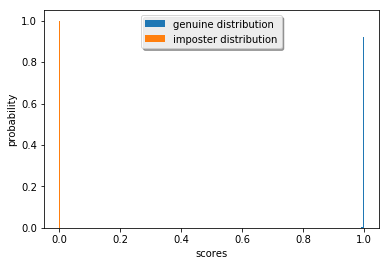

In [9]:
draw_genu_impost_distri(genuine_scores_train, imposter_scores_train)

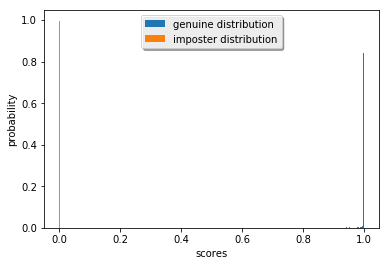

In [10]:
draw_genu_impost_distri(genuine_scores_val, imposter_scores_val)

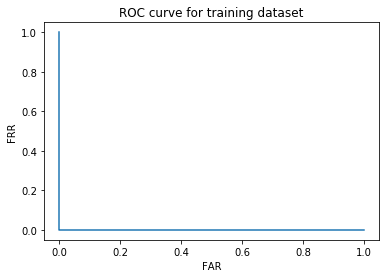

In [11]:
FAR_train,FRR_train = cal_ROC(genuine_scores_train, imposter_scores_train)
plt.plot(FAR_train,FRR_train)
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.title('ROC curve for training dataset')

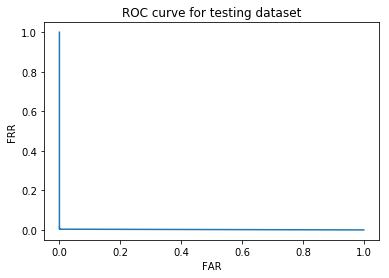

In [12]:
FAR_val,FRR_val = cal_ROC(genuine_scores_val, imposter_scores_val)
plt.plot(FAR_val,FRR_val)
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.title('ROC curve for testing dataset')

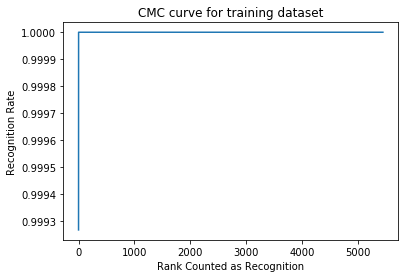

In [13]:
CMC_train = cal_CMC(scores_train.copy(),labels_train.copy())
plt.plot(CMC_train)
plt.xlabel('Rank Counted as Recognition')
plt.ylabel('Recognition Rate')
plt.title('CMC curve for training dataset')

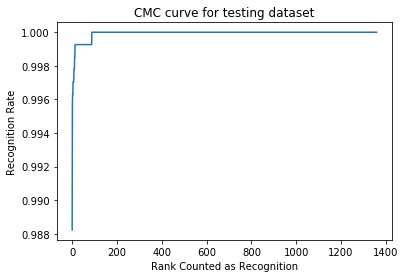

In [14]:
CMC_val = cal_CMC(scores_val.copy(),labels_val.copy())
plt.plot(CMC_val)
plt.xlabel('Rank Counted as Recognition')
plt.ylabel('Recognition Rate')
plt.title('CMC curve for testing dataset')

In [35]:
def show_error(faces,scores,labels):
    t = (np.argmax(scores,axis=1) == labels)
    errors = []
    for i in range(len(t)):
        if not t[i]:
            errors.append(i)
    print("dataset includes %d faces, and the recognition of %d faces are incorrect!!!" % (len(labels),len(errors)))
    for face_id in errors:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(faces[face_id])
        plt.title("correct label is: %d" % labels[face_id])
        plt.subplot(1,2,2)
        plt.plot(scores[face_id])
        plt.title("predictted label is: %d" % np.argmax(scores[face_id]))
        plt.show()

dataset includes 5453 faces, and the recognition of 4 faces are incorrect!!!


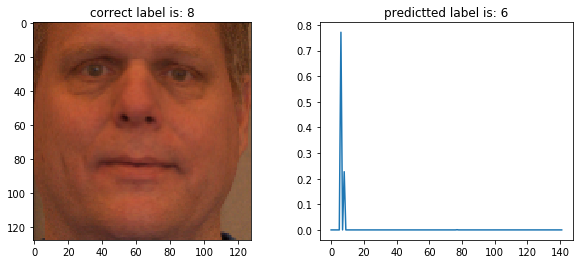

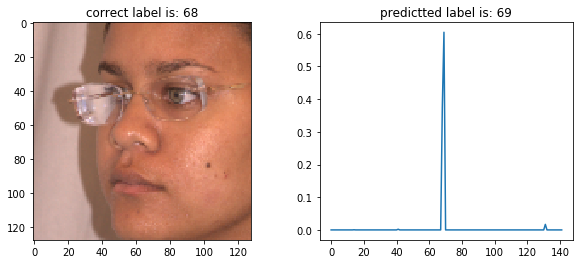

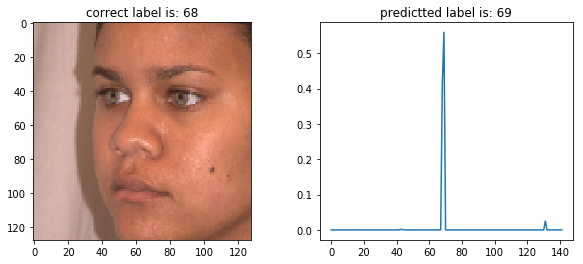

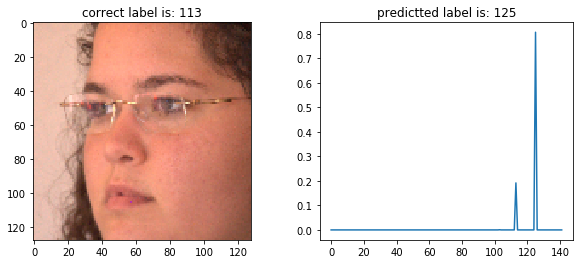

In [36]:
show_error(faces_train,scores_train,labels_train)

dataset includes 1359 faces, and the recognition of 16 faces are incorrect!!!


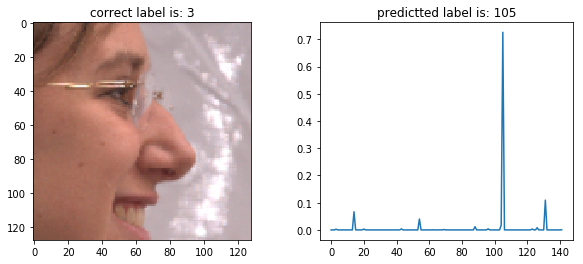

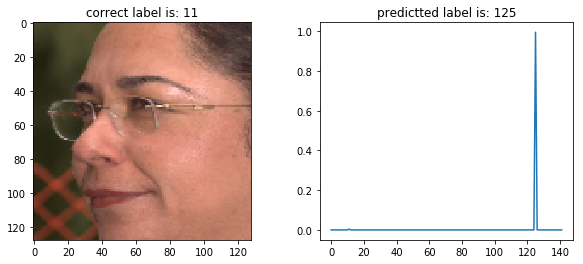

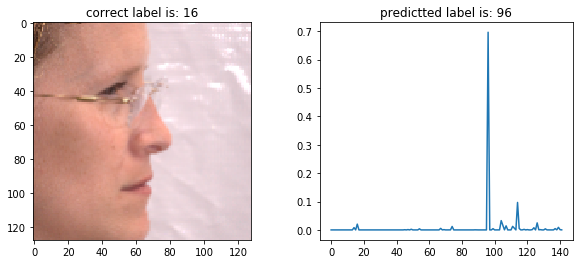

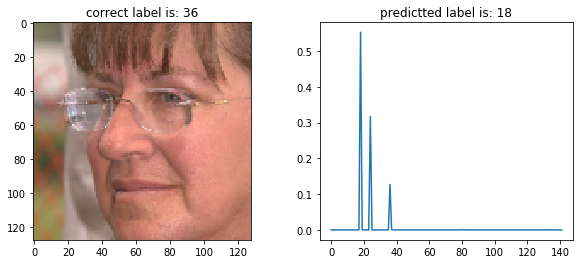

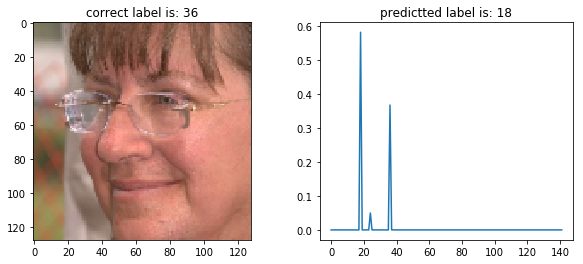

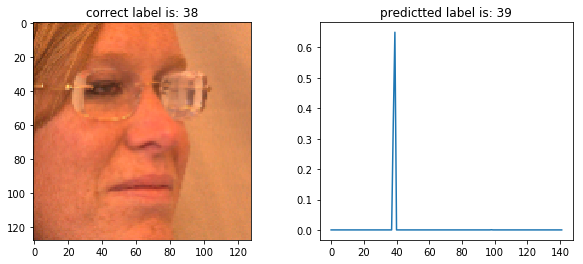

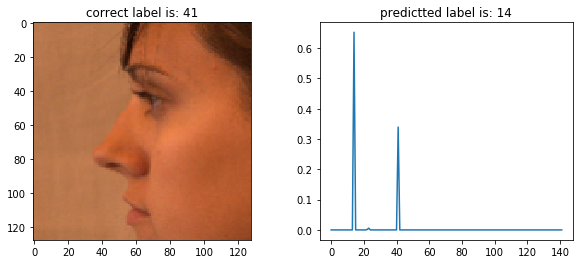

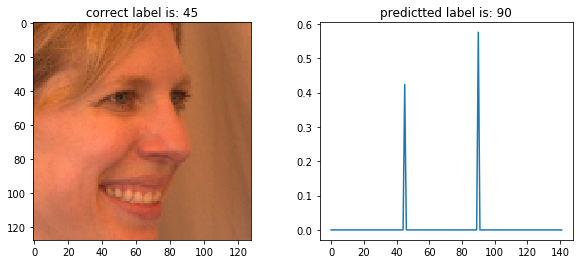

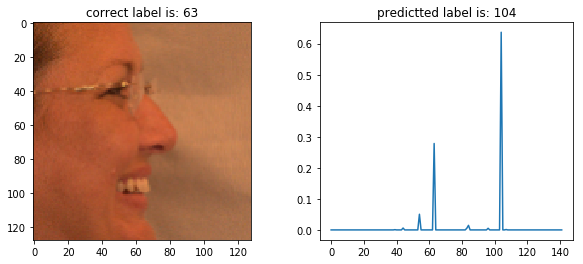

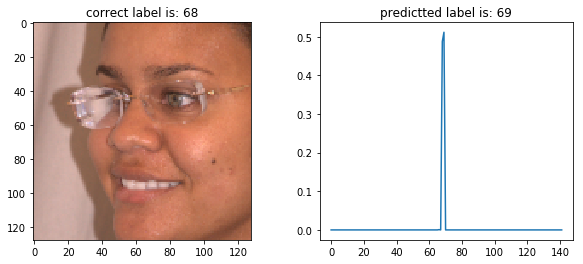

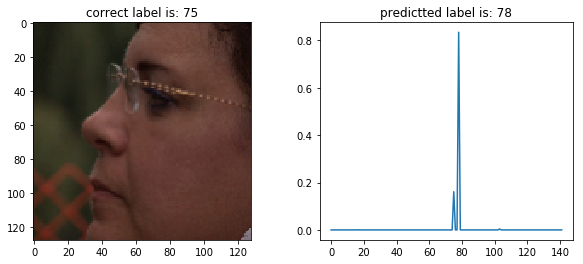

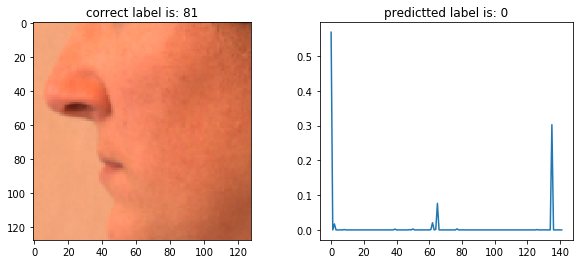

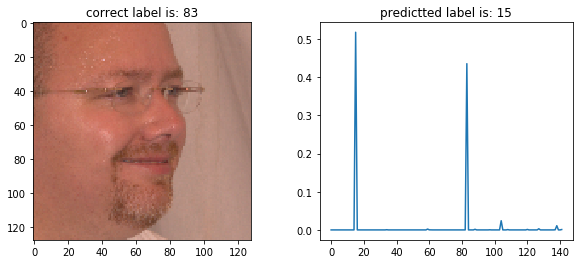

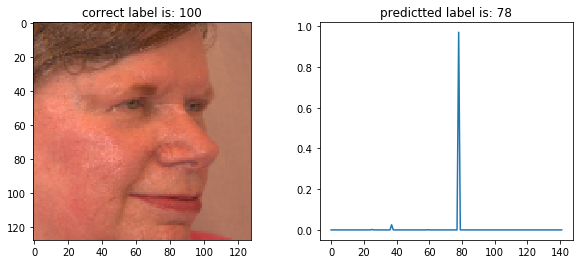

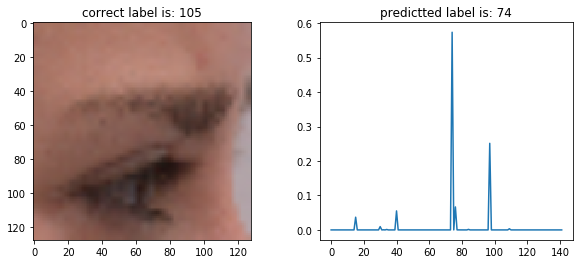

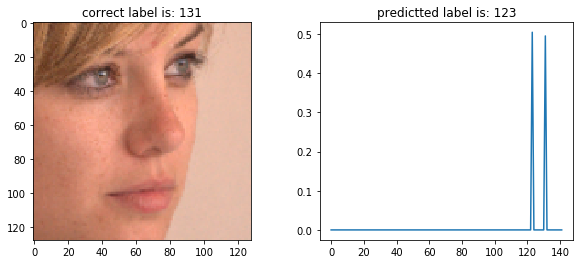

In [37]:
show_error(faces_val,scores_val,labels_val)